## Luke Schwenke
## Advanced Computer Vision
## Homework #3
## August 5, 2023

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import scipy.io
import os
import matplotlib.pyplot as plt
import csv
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as k
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.optimizers import SGD, Adam
from tensorflow.keras.models import load_model

#from classification_models.keras import Classifiers

# Question #1

**Paper Critique**

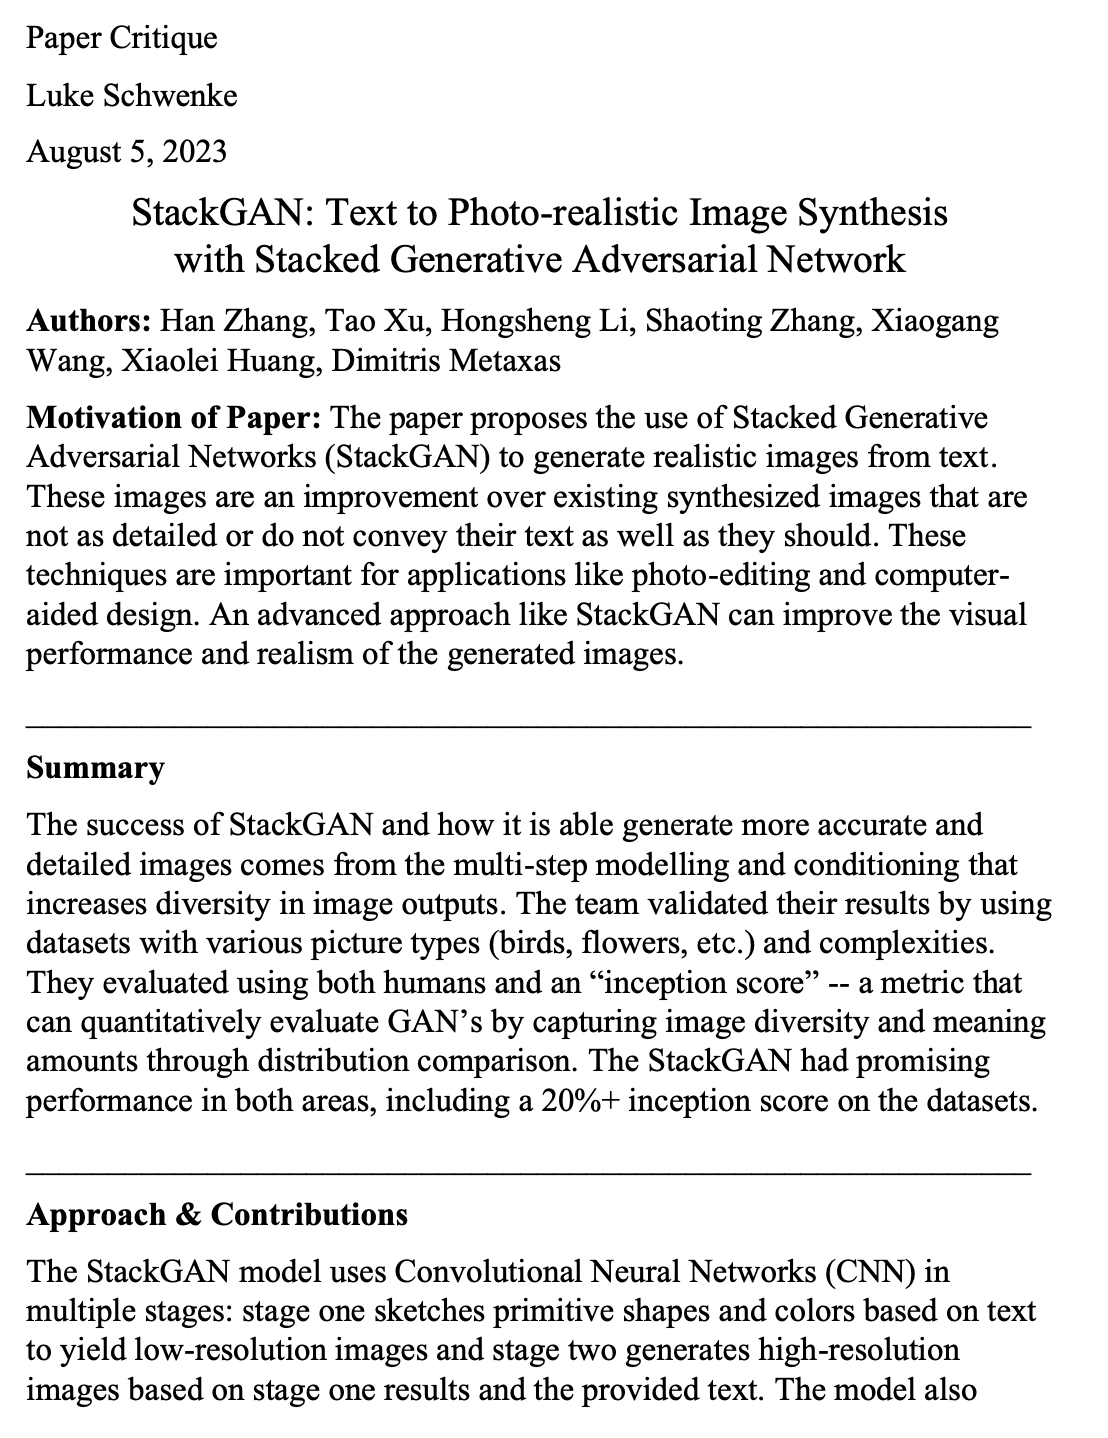

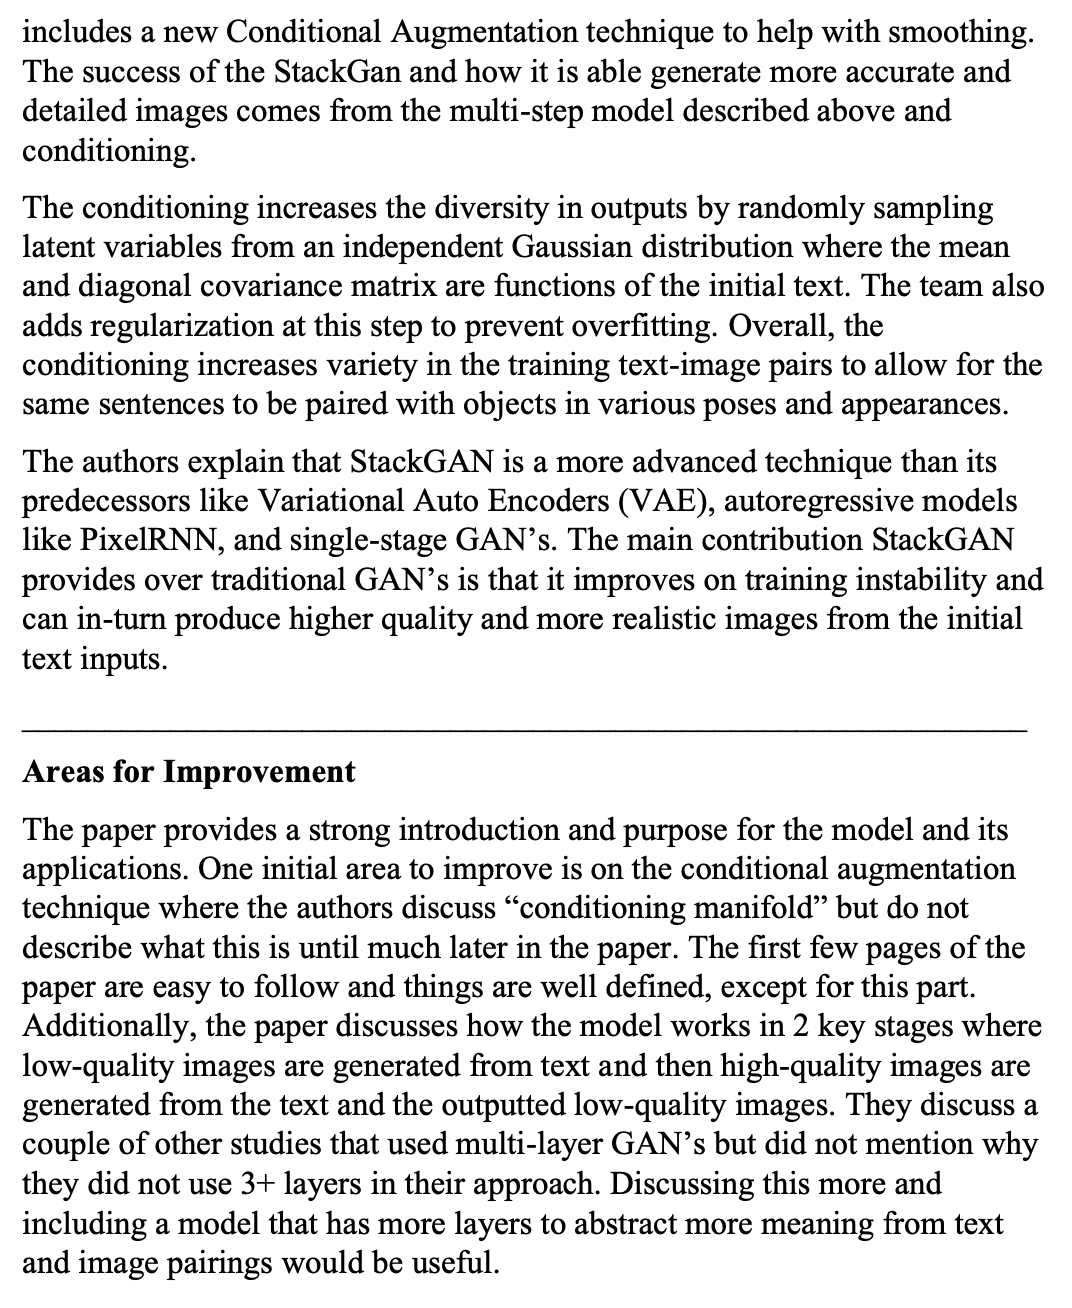

# Question #2

## Data Preprocessing

In [18]:
f = open('/Users/lmschwenke/Downloads/bugs/classes.txt')
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label','name']
classes

,label,name
0,1,rice leaf roller
1,2,rice leaf caterpillar
2,3,paddy stem maggot
3,4,asiatic rice borer
4,5,yellow rice borer
...,...,...
97,98,Chlumetia transversa
98,99,Mango flat beak leafhopper
99,100,Rhytidodera bowrinii white
100,101,Sternochetus frigidus


In [62]:
train_df = pd.read_csv('/Users/lmschwenke/Downloads/bugs/train.txt',sep=' ',header=None, engine='python')
train_df.columns = ['image_path','labels']

test_df = pd.read_csv('/Users/lmschwenke/Downloads/bugs/test.txt',sep=' ',header=None, engine='python')
test_df.columns = ['image_path','labels']

### Balance & Split (80/20)

Balance the dataset by keeping 40 images per class in the Train dataset and 10 images per class in the Test dataset. Subsetting the data in this way also makes the data into an 80% Train / 20% Test split ratio.

In [63]:
def keep_top_n_records_per_label(df, n):
    result_df = pd.DataFrame()
    for label in df['labels'].unique():
        label_df = df[df['labels'] == label].head(n)
        result_df = pd.concat([result_df, label_df])
    return result_df

# Balance the dataset AND make into 80% Train and 20% Test

train_df = keep_top_n_records_per_label(train_df, n=40)
test_df = keep_top_n_records_per_label(test_df, n=10)

In [53]:
train_df.groupby('labels').size().reset_index(name='count').head(5)

,labels,count
0,0,40
1,1,40
2,2,40
3,3,40
4,4,40


In [54]:
test_df.groupby('labels').size().reset_index(name='count').head(5)

,labels,count
0,0,10
1,1,10
2,2,10
3,3,10
4,4,10


In [55]:
train_data_dir = '/Users/lmschwenke/Downloads/bugs/classification/train'
test_data_dir = '/Users/lmschwenke/Downloads/bugs/classification/test'

In [56]:
def delete_extra_files(main_path, file_list):
    for root, directories, files in os.walk(main_path):
        for file in files:
            if file not in file_list:
                os.remove(os.path.join(root, file))

In [58]:
delete_extra_files(main_path='/Users/lmschwenke/Downloads/bugs/classification/train', 
                   file_list=list(train_df.image_path))

In [57]:
base_directory = train_data_dir

# Get a list of folder names in the base directory
folders = os.listdir(base_directory)

# Loop through each folder and count the number of files
for folder in folders:
    folder_path = os.path.join(base_directory, folder)
    if os.path.isdir(folder_path):
        num_files = len(os.listdir(folder_path))
        print(f"Folder '{folder}' contains {num_files} files.")

Folder '61' contains 40 files.
Folder '95' contains 40 files.
Folder '59' contains 40 files.
Folder '92' contains 40 files.
Folder '66' contains 40 files.
Folder '50' contains 40 files.
Folder '68' contains 40 files.
Folder '57' contains 40 files.
Folder '32' contains 40 files.
Folder '35' contains 40 files.
Folder '69' contains 40 files.
Folder '56' contains 40 files.
Folder '51' contains 40 files.
Folder '58' contains 40 files.
Folder '67' contains 40 files.
Folder '93' contains 40 files.
Folder '94' contains 40 files.
Folder '60' contains 40 files.
Folder '34' contains 40 files.
Folder '33' contains 40 files.
Folder '20' contains 40 files.
Folder '18' contains 40 files.
Folder '27' contains 40 files.
Folder '9' contains 40 files.
Folder '0' contains 40 files.
Folder '11' contains 40 files.
Folder '7' contains 40 files.
Folder '29' contains 40 files.
Folder '16' contains 40 files.
Folder '42' contains 40 files.
Folder '89' contains 40 files.
Folder '45' contains 40 files.
Folder '73'

In [66]:
delete_extra_files(main_path='/Users/lmschwenke/Downloads/bugs/classification/test', 
                   file_list=list(test_df.image_path))

In [67]:
base_directory = test_data_dir

# Get a list of folder names in the base directory
folders = os.listdir(base_directory)

# Loop through each folder and count the number of files
for folder in folders:
    folder_path = os.path.join(base_directory, folder)
    if os.path.isdir(folder_path):
        num_files = len(os.listdir(folder_path))
        print(f"Folder '{folder}' contains {num_files} files.")

Folder '61' contains 10 files.
Folder '95' contains 10 files.
Folder '59' contains 10 files.
Folder '92' contains 10 files.
Folder '66' contains 10 files.
Folder '50' contains 10 files.
Folder '68' contains 10 files.
Folder '57' contains 10 files.
Folder '32' contains 10 files.
Folder '35' contains 10 files.
Folder '69' contains 10 files.
Folder '56' contains 10 files.
Folder '51' contains 10 files.
Folder '58' contains 10 files.
Folder '67' contains 10 files.
Folder '93' contains 10 files.
Folder '94' contains 10 files.
Folder '60' contains 10 files.
Folder '34' contains 10 files.
Folder '33' contains 10 files.
Folder '20' contains 10 files.
Folder '18' contains 10 files.
Folder '27' contains 10 files.
Folder '9' contains 10 files.
Folder '0' contains 10 files.
Folder '11' contains 10 files.
Folder '7' contains 10 files.
Folder '29' contains 10 files.
Folder '16' contains 10 files.
Folder '42' contains 10 files.
Folder '89' contains 10 files.
Folder '45' contains 10 files.
Folder '73'

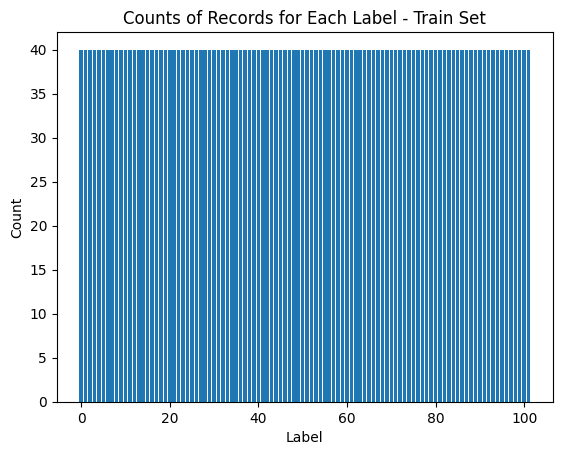

In [68]:
counts_train = train_df.groupby('labels').size().reset_index(name='count')
plt.bar(counts_train['labels'], counts_train['count'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Counts of Records for Each Label - Train Set')
#plt.xticks(counts_train['label'])  # Optional: Set the x-axis tick labels to the unique labels
plt.show()

In [75]:
def count_jpg_files(directory_path):
    jpg_count = 0

    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(".jpg"):
                jpg_count += 1

    return jpg_count

print('Train Files:',count_jpg_files(train_data_dir))
print('Test Files:',count_jpg_files(test_data_dir))

print('Percent Split of Train:',count_jpg_files(train_data_dir)/(count_jpg_files(train_data_dir)+count_jpg_files(test_data_dir)))
print('Percent Split of Test:',count_jpg_files(test_data_dir)/(count_jpg_files(train_data_dir)+count_jpg_files(test_data_dir)))

Train Files: 4080
Test Files: 1020
Percent Split of Train: 0.8
Percent Split of Test: 0.2


### Data Augmentation

In [76]:
datagen = ImageDataGenerator(rotation_range=10,
            rescale = 1.0/255.0,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=False,
            zoom_range=0.1,
            shear_range=0.1,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest')

In [95]:
trainimagedata = datagen.flow_from_directory("/Users/lmschwenke/Downloads/bugs/classification/train",
                                              batch_size = 512,
                                              class_mode = 'categorical',
                                              target_size=(64,64),
                                              subset = 'training'
                                            )

testimagedata = datagen.flow_from_directory("/Users/lmschwenke/Downloads/bugs/classification/test",
                                              batch_size = 256,
                                              class_mode = 'categorical',
                                              target_size=(64,64)
                                            )

valimagedata = datagen.flow_from_directory("/Users/lmschwenke/Downloads/bugs/classification/val",
                                              batch_size = 256,
                                              class_mode = 'categorical',
                                              target_size=(64,64),
                                              subset = 'training'
                                            ) # Not subsetted

Found 4080 images belonging to 102 classes.
Found 1020 images belonging to 102 classes.
Found 7508 images belonging to 102 classes.


# Model #1: Custom CNN

In [124]:
# Model Architecture
input_shape = trainimagedata.image_shape

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(128,(3,3), input_shape = input_shape,activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D(2,2))

model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(2,2))

model.add(tf.keras.layers.Flatten())

model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(102,activation = 'softmax'))

In [125]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.001,beta_1 = 0.9 ,beta_2= 0.999 , epsilon = 1e-07)

In [126]:
model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [127]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 64)        73792     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 14400)             0         
                                                                 
 dense_9 (Dense)             (None, 256)              

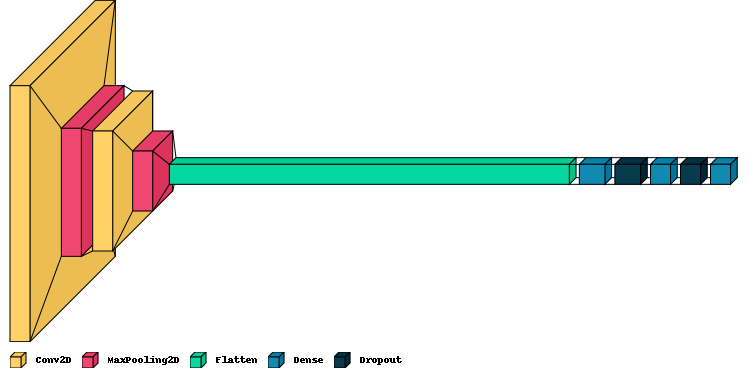

In [128]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

In [129]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience =3)

In [130]:
# Fitting the model
with tf.device('/device:GPU:0'):
    custom_cnn_history = model.fit(trainimagedata,
                          validation_data = testimagedata,
                          epochs= 5,
                          batch_size=512,
                          callbacks=[early_stop])

Epoch 1/5
8/8 [==============================] - 14s 2s/step - loss: 4.7799 - accuracy: 0.0093 - val_loss: 4.6312 - val_accuracy: 0.0108
Epoch 2/5
8/8 [==============================] - 13s 2s/step - loss: 4.6344 - accuracy: 0.0115 - val_loss: 4.6239 - val_accuracy: 0.0118
Epoch 3/5
8/8 [==============================] - 13s 2s/step - loss: 4.6242 - accuracy: 0.0088 - val_loss: 4.6212 - val_accuracy: 0.0078
Epoch 4/5
8/8 [==============================] - 12s 2s/step - loss: 4.6217 - accuracy: 0.0098 - val_loss: 4.6170 - val_accuracy: 0.0118
Epoch 5/5
8/8 [==============================] - 12s 2s/step - loss: 4.6248 - accuracy: 0.0098 - val_loss: 4.6152 - val_accuracy: 0.0137


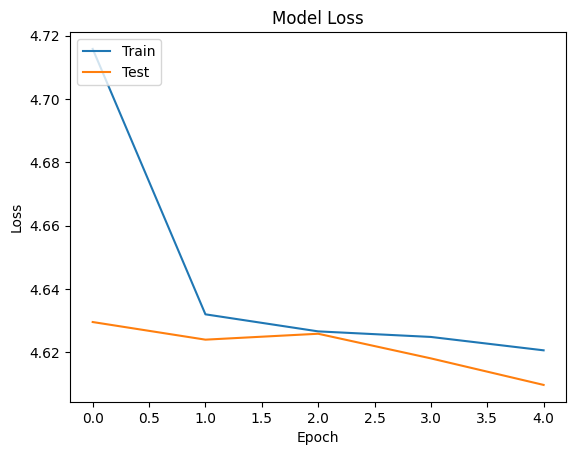

In [85]:
plt.plot(custom_cnn_history.history['loss'])
plt.plot(custom_cnn_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

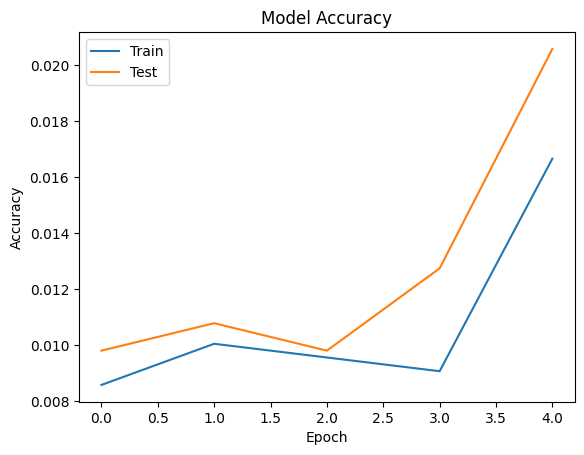

In [86]:
plt.plot(custom_cnn_history.history['accuracy'])
plt.plot(custom_cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [131]:
model.save("/Users/lmschwenke/Downloads/bugs/cnn_model.h5")

/Users/lmschwenke/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Custom CNN Summary

The given model is a sequential neural network with a total of 7 layers. It begins with two convolutional layers followed by max-pooling layers for downsampling. The next steps include a flatten layer and two dense layers, each with dropout regularization to mitigate overfitting. The model concludes with a final dense layer with 102 neurons, representing the number of output classes. The total number of parameters in this model is 3,790,086.

Manual Parameter Calculation:

* Conv2D layer 1:
filter_height = 3
filter_width = 3
input_channels = 3 (assuming RGB images with 3 channels)
output_channels = 128
Params = (3 * 3 * 3 + 1) * 128 = 3584
* MaxPooling2D layer 1:
(MaxPooling layers have no trainable parameters, so params = 0)
* Conv2D layer 2:
filter_height = 3
filter_width = 3
input_channels = 128 (output channels from the previous Conv2D layer)
output_channels = 64
Params = (3 * 3 * 128 + 1) * 64 = 73792
* MaxPooling2D layer 2:
(MaxPooling layers have no trainable parameters, so params = 0)
* Flatten layer:
(Flatten layers have no trainable parameters, so params = 0)
* Dense layer 1:
input_shape = 14400 (output shape from the previous Flatten layer)
output_shape = 256
Params = (14400 + 1) * 256 = 3686656
* Dropout layer 1:
(Dropout layers have no trainable parameters, so params = 0)
* Dense layer 2:
input_shape = 256 (output shape from the previous Dense layer)
output_shape = 128
Params = (256 + 1) * 128 = 32896

* Dropout layer 2:
(Dropout layers have no trainable parameters, so params = 0)

* Dense layer 3:
input_shape = 128 (output shape from the previous Dense layer)
output_shape = 102
Params = (128 + 1) * 102 = 13158

Now, add up the parameters from all the layers:

Total params = 3584 + 73792 + 3686656 + 32896 + 13158 = 3,790,086

# Model #2: Transfer Learning - ResNet50

In [192]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [202]:
model_name='ResNet50'
base_model=tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                          weights="imagenet",
                                          input_shape=trainimagedata.image_shape, 
                                          pooling='max') 

# Freeze Layers
for layer in base_model.layers[:20]:
    layer.trainable = False

# Add Custom Layers
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, 
                                  momentum=0.99, 
                                  epsilon=0.001 )(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),
               activity_regularizer=regularizers.l1(0.006),
               bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.2, seed=345)(x)        
output=Dense(102, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [203]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_12[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 16, 16, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 16, 16, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 16, 16, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 8, 8, 512)            66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 8, 8, 512)            0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 4, 4, 256)            590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 4, 4, 256)            1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 4, 4, 256)            0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 4, 4, 1024)           525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 4, 4, 1024)           0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 4, 4, 256)            262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 4, 4, 256)            1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 4, 4, 1024)           4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 4, 4, 1024)           0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 4, 4, 1024)           0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 2, 2, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 2, 2, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 2, 2, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 2, 2, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [204]:
with tf.device('/device:GPU:0'):
    resnet_history = model.fit(trainimagedata,
                          validation_data = valimagedata,
                          epochs= 5,
                          batch_size=512,
                          callbacks=[early_stop])

Epoch 1/5
8/8 [==============================] - 33s 4s/step - loss: 19.0899 - accuracy: 0.0118 - val_loss: 1170.8286 - val_accuracy: 0.0105
Epoch 2/5
8/8 [==============================] - 29s 4s/step - loss: 15.4293 - accuracy: 0.0105 - val_loss: 67866.1406 - val_accuracy: 0.0053
Epoch 3/5
8/8 [==============================] - 28s 4s/step - loss: 13.4399 - accuracy: 0.0100 - val_loss: 215974.2812 - val_accuracy: 0.0068
Epoch 4/5
8/8 [==============================] - 29s 4s/step - loss: 11.5912 - accuracy: 0.0130 - val_loss: 100673.8594 - val_accuracy: 0.0226


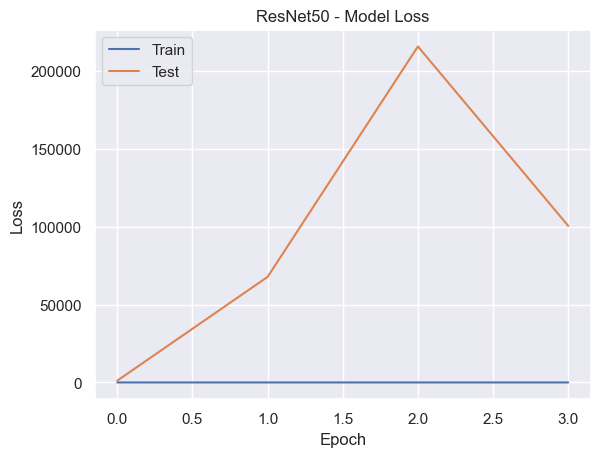

In [206]:
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('ResNet50 - Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

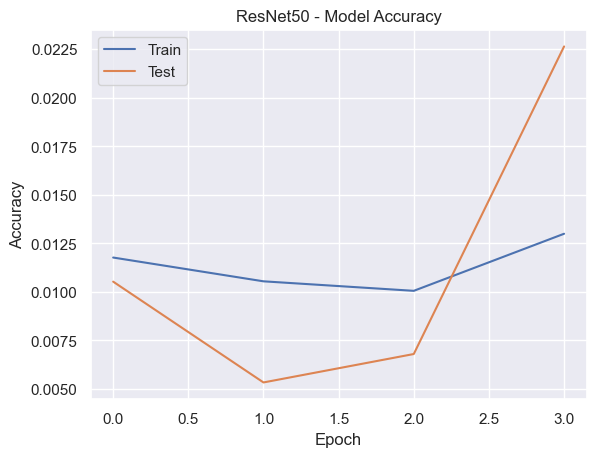

In [207]:
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('ResNet50 - Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [208]:
model.save("/Users/lmschwenke/Downloads/bugs/resnet_model.h5")

/Users/lmschwenke/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model Comparison

**CNN Accuracy:** The accuracy over epochs for the Custom CNN model starts to increase sharply after epoch 2. Both train and test sets follow similar patterns with similar results. Overall the model accuracy is low in the single-digits. Continuous iteration on this model would help capture more of the underlying patterns.

**ResNet50 Accuracy:** The accuracy over epochs for the ResNet50 model has a dip in the test accuracy that then increases at epoch 2. The results were farily similar to the Custom CNN model. The train accuracy remained pretty static whereas the test accuracy increased.

**Performance Comparison:** Both models had similar performance from an accuracy standpoint (around 2%). This dataset has 102 classes to classify and we subsetted the data to a much smaller number of images to balances the classes and allow the models to train in a reasonable time on local hardware. Future iterations that include the full dataset, larger computer resources on a TPU/GPU, inceased training time with epochs, and more refined model architectures would benefit this dataset classification.

**Test Example (Web Application - below):** The test example within the web application shows the Custom CNN model classifying the bug picture as 65% Dacus Dorsalis (Hendel) and 33% Nipaecoccus Vastalor. The ResNet50 model on the other hand just predicted 100% to the white margined moth.

## Web Application

The web application was created in VScode, the files are attached separately. Please see the screenshots below showing an example process of an image being submitted and the prediction from the trained model.

The application allows the user to select the Custom CNN or ResNet model to make the prediction on their uploaded image. The page dynamically updates and runs the appropriate model.

### Example:

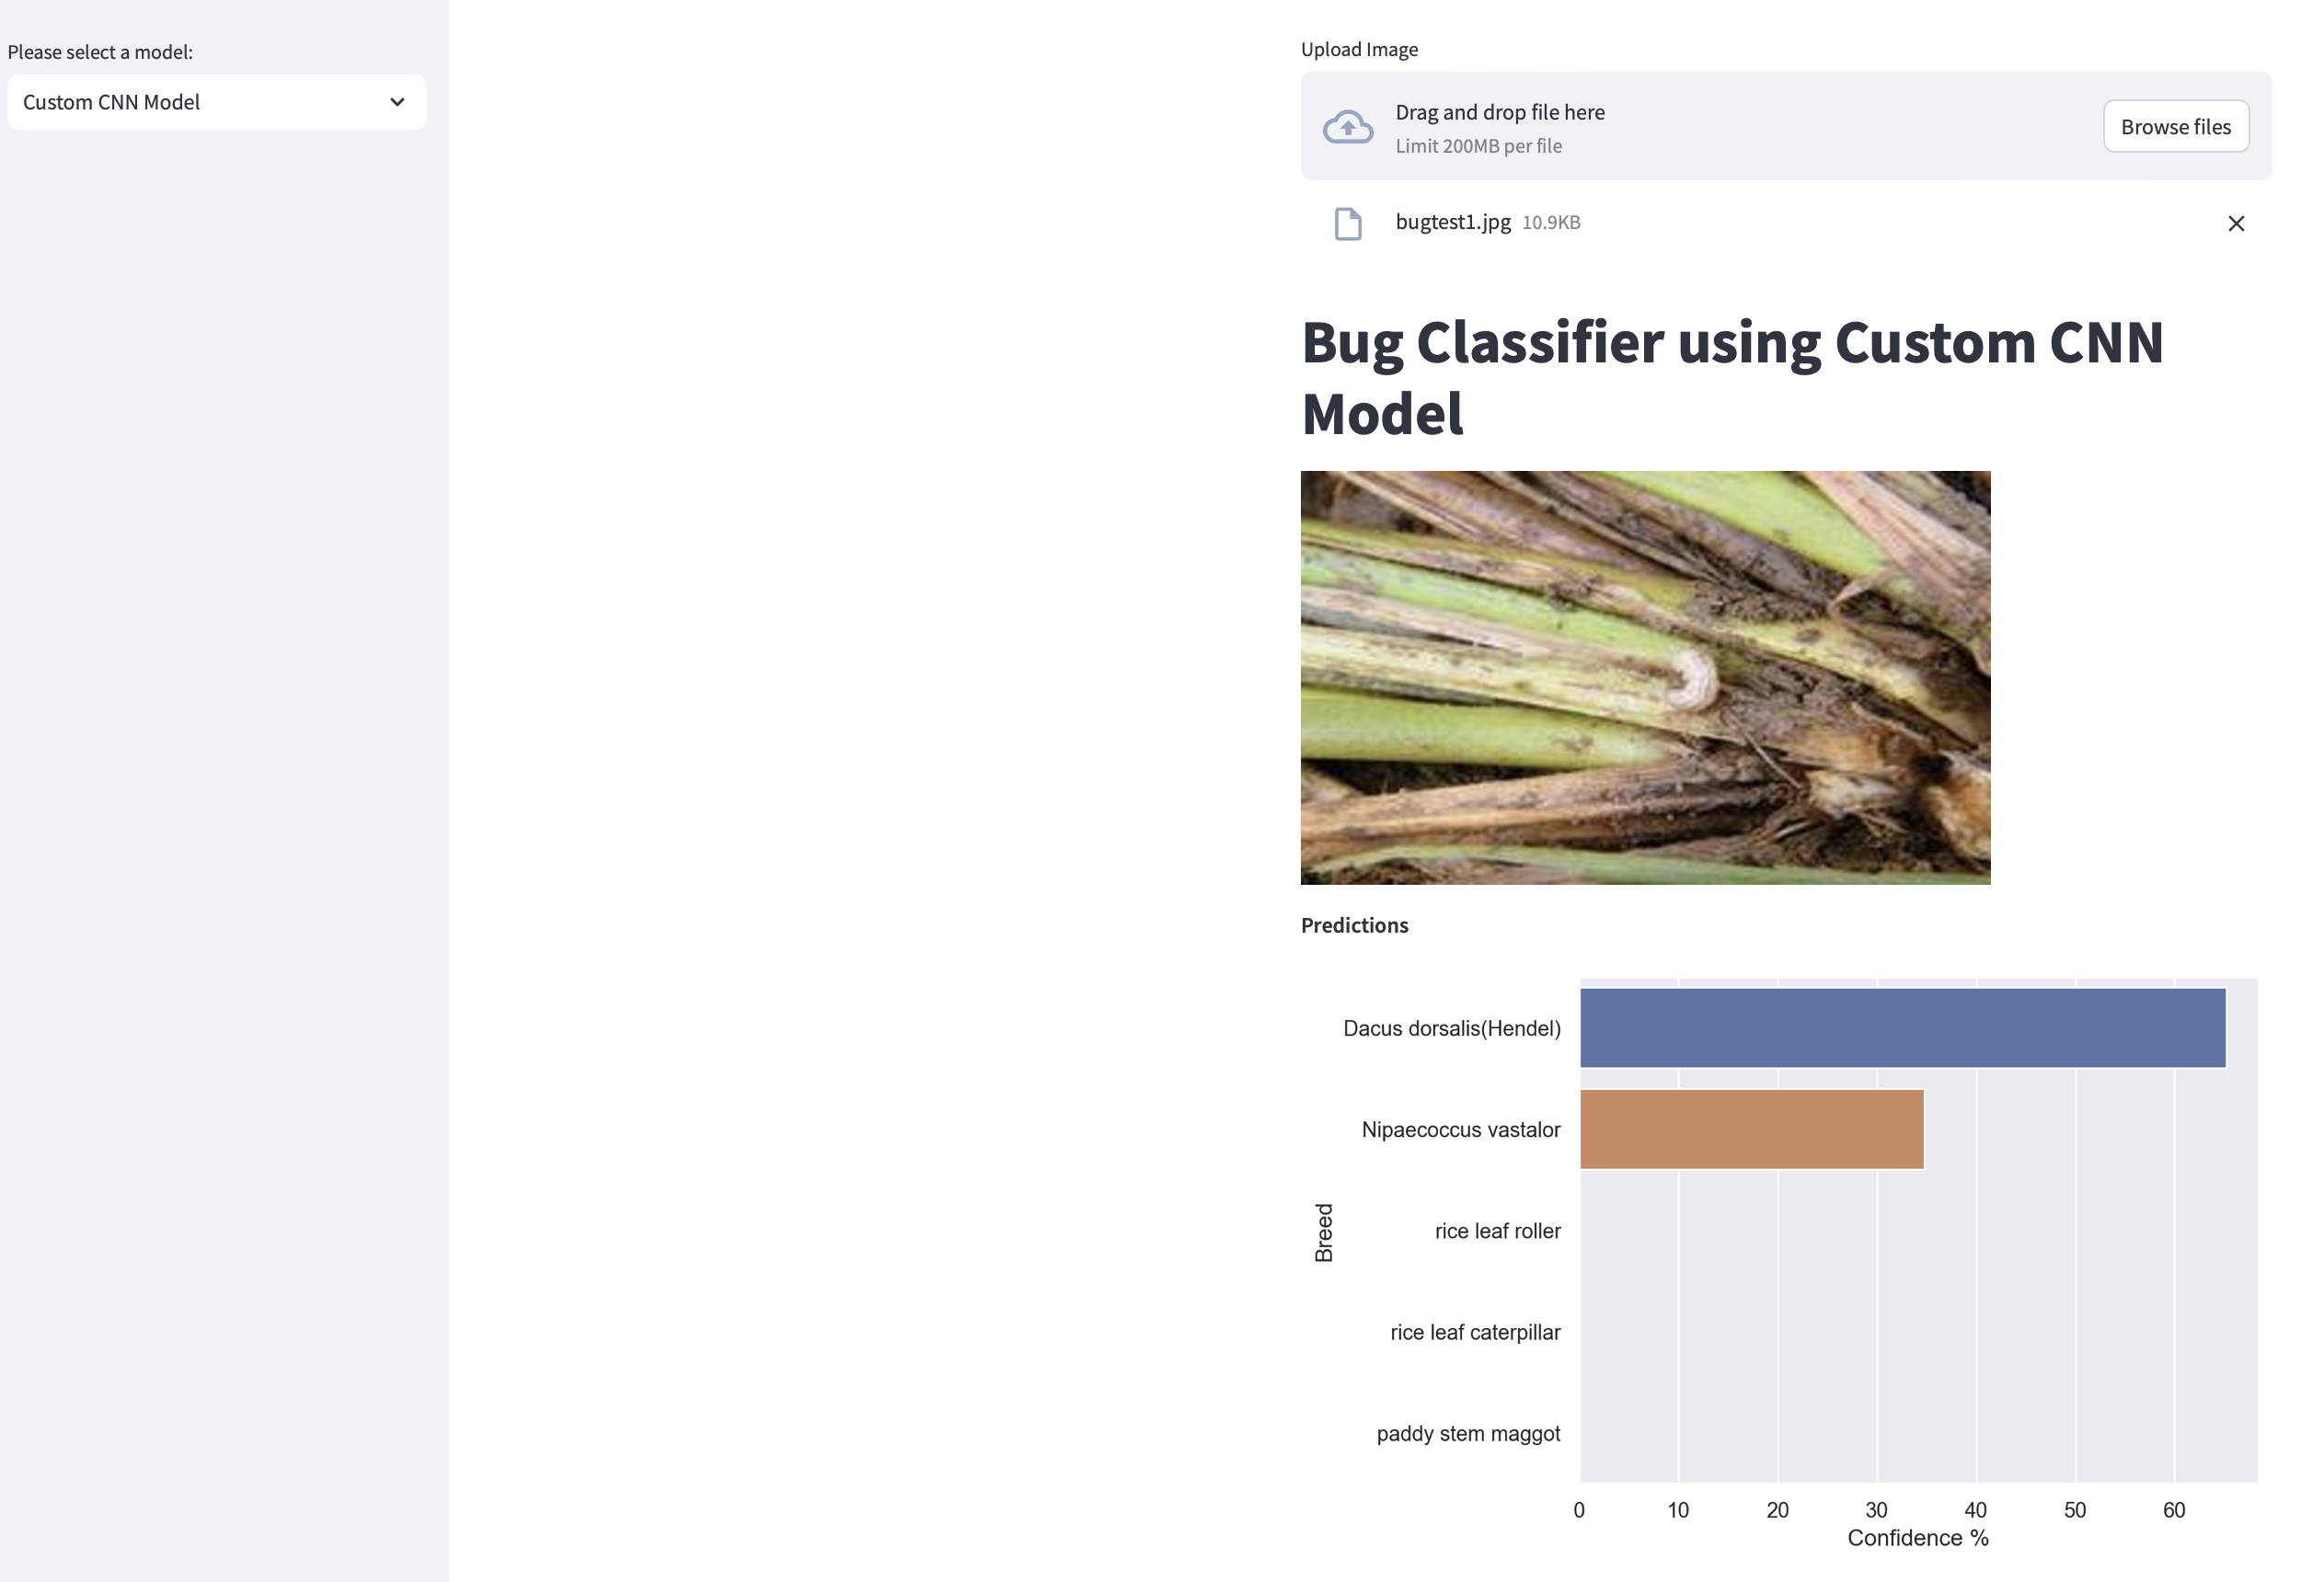

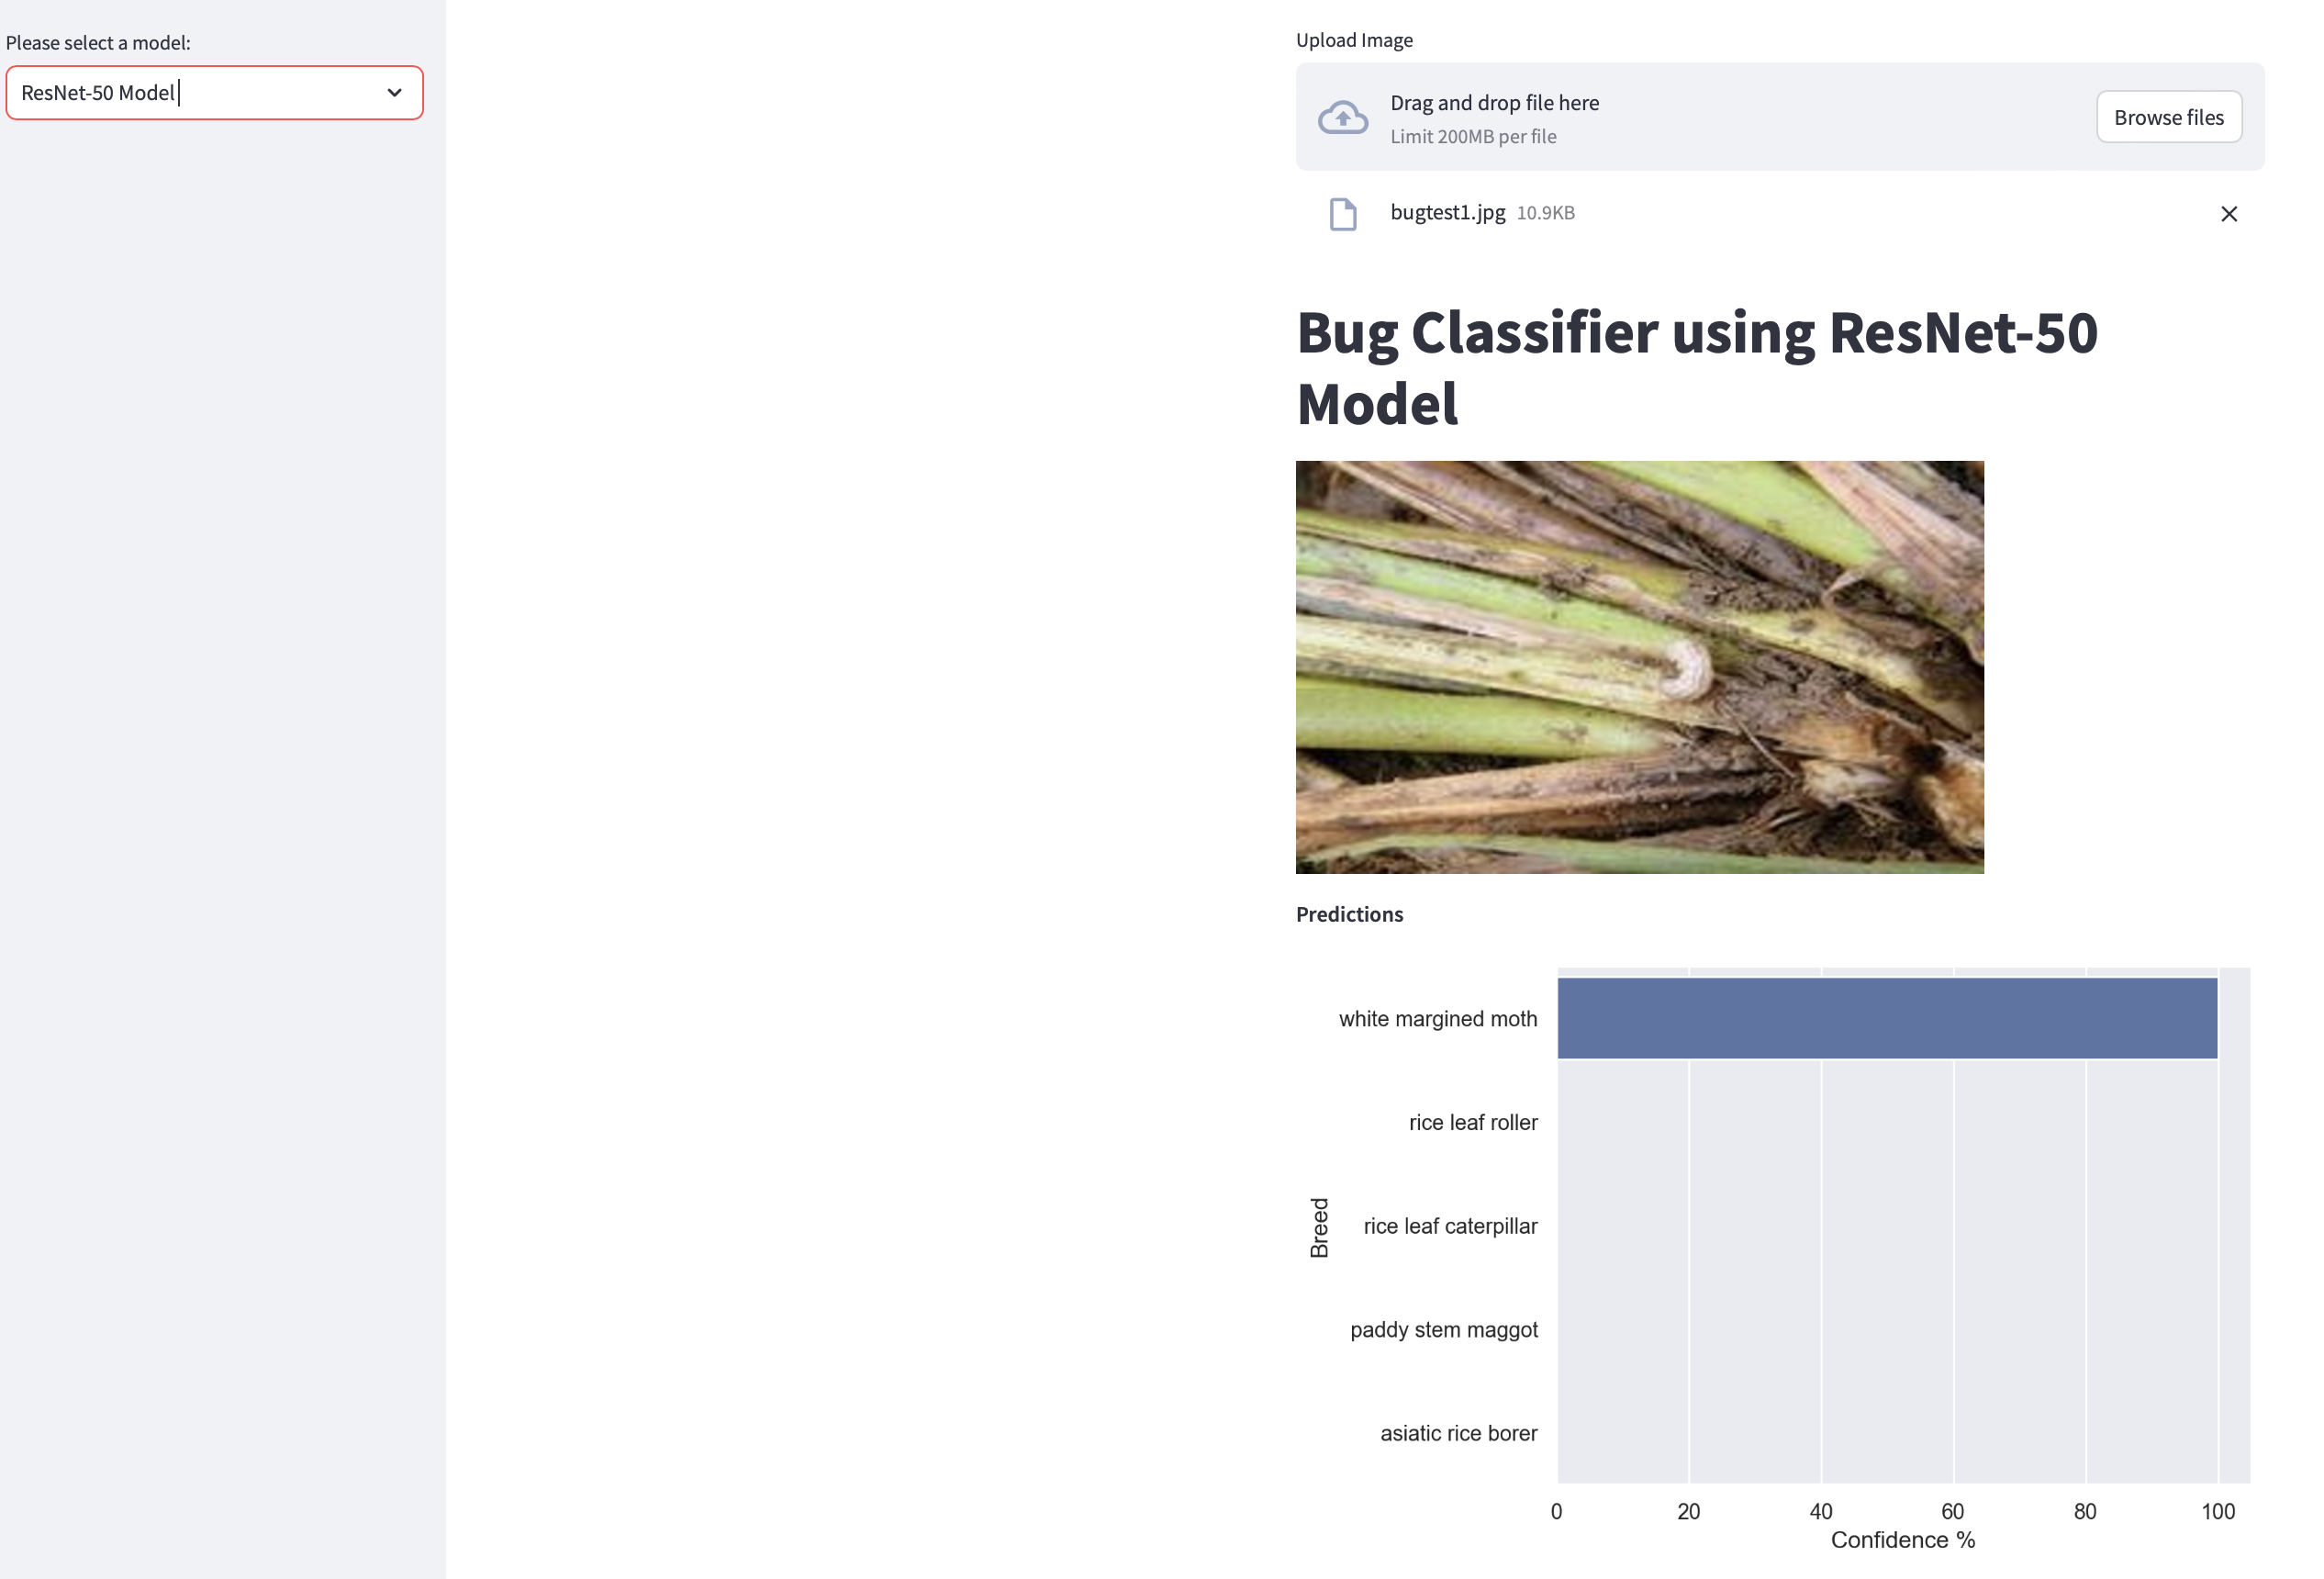

# Question #3

Build two RNNs (an LSTM and GRU) models each to learn the Sine wave and the arbitrary function from
Assignment 2 (20)

* Summarize the model architectures.
* Provide a manual calculation for the total number of parameters for each model.
* Compare the RNN model performance with the MLP used for Assignment 2.

In [98]:
# Sine
import numpy as np

X = np.linspace(-np.pi, np.pi, 10000)
X = X.reshape(-1, 1)
X = X.reshape(-1, 1, 1)

y = np.sin(X)
y = y.reshape(-1, 1)

### LSTM - Sine Wave

In [99]:
tsteps = 1
batch_size = 25
epochs = 100

model = Sequential()
model.add(LSTM(50, batch_input_shape=(batch_size, tsteps, 1), return_sequences=True, stateful=True))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [100]:
print("Model Parameters :", model.count_params())
print("Output Shape :", model.output_shape)

model.summary()

Model Parameters : 10451
Output Shape : (25, 1, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (25, 1, 50)               10400     
                                                                 
 dense_5 (Dense)             (25, 1, 1)                51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [101]:
#Train an LSTM model
print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)
    model.fit(X,
              y,
              batch_size=batch_size,
              verbose=1,
              epochs=1,
              shuffle=False)
    model.reset_states()

Training
Epoch 0 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0056
Epoch 1 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0099
Epoch 2 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0335
Epoch 3 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0193
Epoch 4 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0135
Epoch 5 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0095
Epoch 6 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0104
Epoch 7 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0118
Epoch 8 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0161
Epoch 9 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0187
Epoch 10 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0206
Epoch 11 / 100
400/400 [==============================] - 2s 4ms/s

400/400 [==============================] - 2s 4ms/step - loss: 2.4261e-04
Epoch 95 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0012
Epoch 96 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0026
Epoch 97 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0015
Epoch 98 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0016
Epoch 99 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0018


In [102]:
print('Predicting')
predicted_output = model.predict(X, batch_size=batch_size)
predicted_output = np.squeeze(predicted_output, axis=(2,))

predicted_output.shape
y.shape #expected output

Predicting
400/400 [==============================] - 1s 2ms/step


(10000, 1)

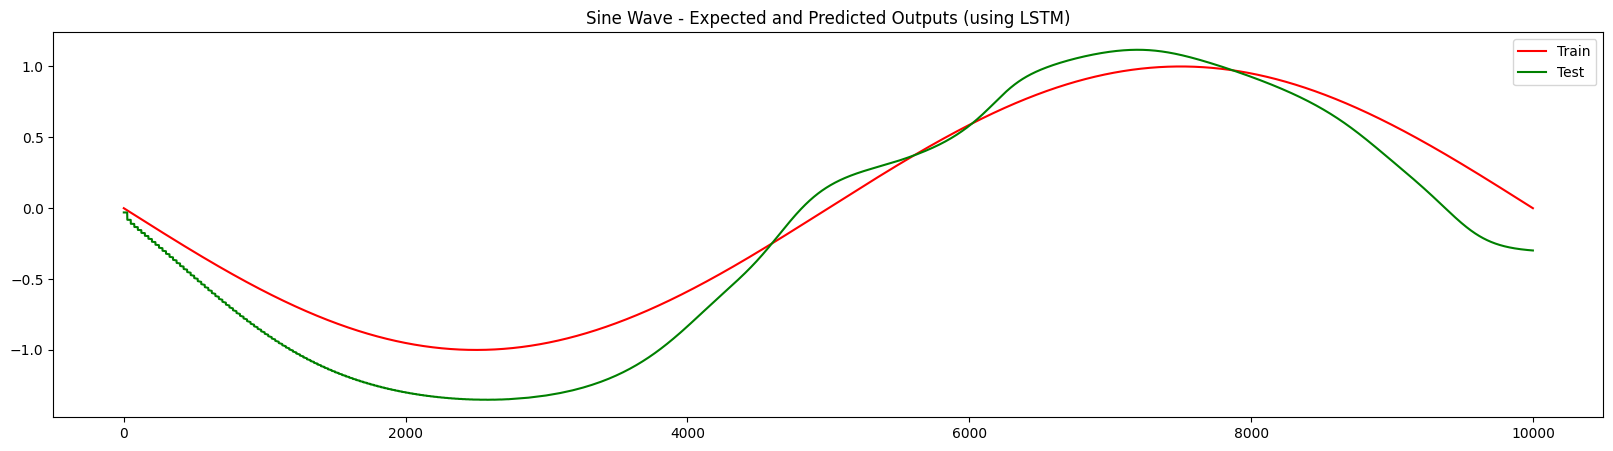

In [103]:
plt.figure(figsize=(20,5))
plt.plot(y, "red", label='Train')
plt.plot(predicted_output, "green", label='Test')
plt.title('Sine Wave - Expected and Predicted Outputs (using LSTM)')
plt.legend()
plt.show()

### GRU - Sine Wave

In [104]:
model = Sequential()
model.add(GRU(50, batch_input_shape=(batch_size, tsteps, 1), return_sequences=True, stateful=True))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [105]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (25, 1, 50)               7950      
                                                                 
 dense_6 (Dense)             (25, 1, 1)                51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [106]:
#Train an GRU model

print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)
    model.fit(X,
              y,
              batch_size=batch_size,
              verbose=1,
              epochs=1,
              shuffle=False)
    model.reset_states()

Training
Epoch 0 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0023
Epoch 1 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0010
Epoch 2 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0176
Epoch 3 / 100
400/400 [==============================] - 1s 4ms/step - loss: 0.0219
Epoch 4 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0204
Epoch 5 / 100
400/400 [==============================] - 1s 4ms/step - loss: 0.0176
Epoch 6 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0195
Epoch 7 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0120
Epoch 8 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0134
Epoch 9 / 100
400/400 [==============================] - 1s 4ms/step - loss: 0.0082
Epoch 10 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0248
Epoch 11 / 100
400/400 [==============================] - 2s 4ms/s

400/400 [==============================] - 1s 4ms/step - loss: 1.1762e-04
Epoch 95 / 100
400/400 [==============================] - 2s 4ms/step - loss: 3.2023e-04
Epoch 96 / 100
400/400 [==============================] - 1s 4ms/step - loss: 5.1391e-04
Epoch 97 / 100
400/400 [==============================] - 2s 4ms/step - loss: 2.2697e-04
Epoch 98 / 100
400/400 [==============================] - 2s 4ms/step - loss: 1.6314e-04
Epoch 99 / 100
400/400 [==============================] - 2s 4ms/step - loss: 5.5712e-04


In [107]:
print('Predicting')
predicted_output = model.predict(X, batch_size=batch_size)
predicted_output = np.squeeze(predicted_output, axis=(2,))

predicted_output.shape
y.shape

Predicting
400/400 [==============================] - 1s 1ms/step


(10000, 1)

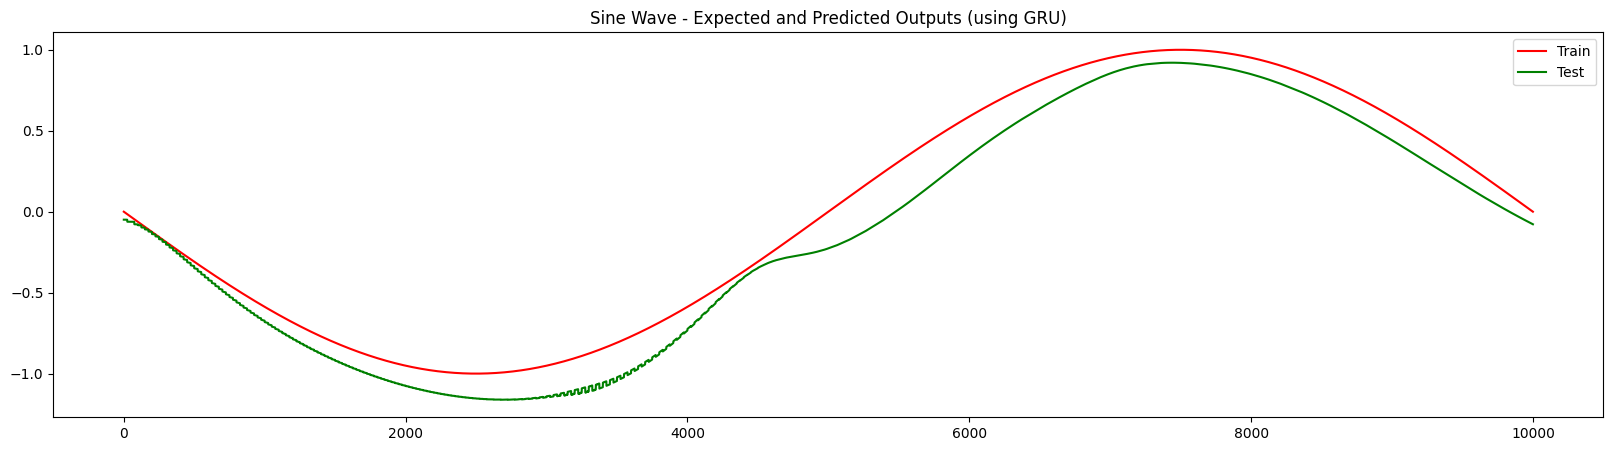

In [108]:
plt.figure(figsize=(20,5))
plt.plot(y, "red", label='Train')
plt.plot(predicted_output, "green", label='Test')
plt.title('Sine Wave - Expected and Predicted Outputs (using GRU)')
plt.legend()
plt.show()

In [109]:
# Sigmoid
X = np.linspace(-np.pi, np.pi, 10000)
X = X.reshape(-1, 1)
X = X.reshape(-1, 1, 1)

y = 1 / (1 + np.exp(-X))
y = y.reshape(-1, 1)

### LSTM - Sigmoid

In [110]:
model = Sequential()
model.add(LSTM(50, batch_input_shape=(batch_size, tsteps, 1), return_sequences=True, stateful=True))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [111]:
print("Model Parameters :", model.count_params())
print("Output Shape :", model.output_shape)

model.summary()

Model Parameters : 10451
Output Shape : (25, 1, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (25, 1, 50)               10400     
                                                                 
 dense_7 (Dense)             (25, 1, 1)                51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [112]:
#Train an LSTM model
print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)
    model.fit(X,
              y,
              batch_size=batch_size,
              verbose=1,
              epochs=1,
              shuffle=False)
    model.reset_states()

Training
Epoch 0 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0350
Epoch 1 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0038
Epoch 2 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0036
Epoch 3 / 100
400/400 [==============================] - 2s 4ms/step - loss: 5.4753e-04
Epoch 4 / 100
400/400 [==============================] - 2s 4ms/step - loss: 9.1990e-04
Epoch 5 / 100
400/400 [==============================] - 2s 5ms/step - loss: 8.5542e-04
Epoch 6 / 100
400/400 [==============================] - 2s 4ms/step - loss: 6.0169e-04
Epoch 7 / 100
400/400 [==============================] - 2s 4ms/step - loss: 6.0030e-04
Epoch 8 / 100
400/400 [==============================] - 2s 4ms/step - loss: 5.4323e-04
Epoch 9 / 100
400/400 [==============================] - 2s 4ms/step - loss: 4.5605e-04
Epoch 10 / 100
400/400 [==============================] - 2s 4ms/step - loss: 3.5139e-04
Epoch 11 / 100
400/400 [==========

400/400 [==============================] - 1s 4ms/step - loss: 3.6700e-06
Epoch 93 / 100
400/400 [==============================] - 2s 4ms/step - loss: 1.9275e-06
Epoch 94 / 100
400/400 [==============================] - 2s 4ms/step - loss: 1.2837e-06
Epoch 95 / 100
400/400 [==============================] - 2s 4ms/step - loss: 3.0237e-05
Epoch 96 / 100
400/400 [==============================] - 2s 4ms/step - loss: 2.2620e-06
Epoch 97 / 100
400/400 [==============================] - 2s 4ms/step - loss: 3.8207e-05
Epoch 98 / 100
400/400 [==============================] - 2s 4ms/step - loss: 5.1561e-06
Epoch 99 / 100
400/400 [==============================] - 2s 4ms/step - loss: 1.3567e-06


In [113]:
print('Predicting')
predicted_output = model.predict(X, batch_size=batch_size)
predicted_output = np.squeeze(predicted_output, axis=(2,))

predicted_output.shape
y.shape #expected output

Predicting
400/400 [==============================] - 1s 2ms/step


(10000, 1)

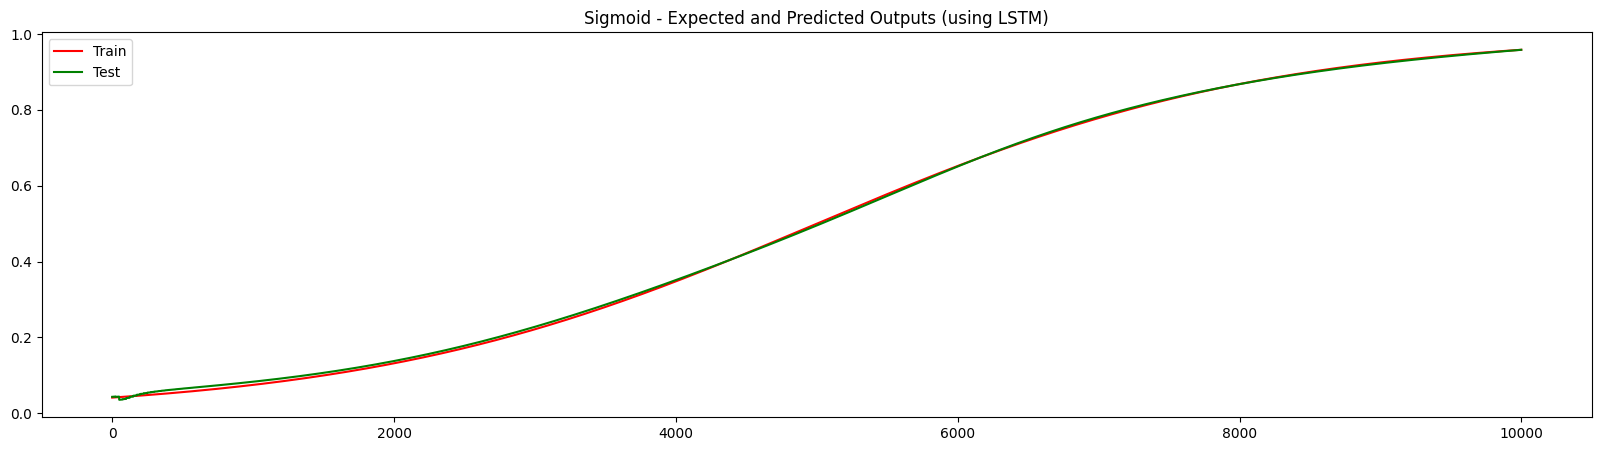

In [114]:
plt.figure(figsize=(20,5))
plt.plot(y, "red", label='Train')
plt.plot(predicted_output, "green", label='Test')
plt.title('Sigmoid - Expected and Predicted Outputs (using LSTM)')
plt.legend()
plt.show()

### GRU - Sigmoid

In [115]:
model = Sequential()
model.add(GRU(50, batch_input_shape=(batch_size, tsteps, 1), return_sequences=True, stateful=True))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [116]:
print("Model Parameters :", model.count_params())
print("Output Shape :", model.output_shape)

model.summary()

Model Parameters : 8001
Output Shape : (25, 1, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (25, 1, 50)               7950      
                                                                 
 dense_8 (Dense)             (25, 1, 1)                51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [117]:
#Train a GRU model
print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)
    model.fit(X,
              y,
              batch_size=batch_size,
              verbose=1,
              epochs=1,
              shuffle=False)
    model.reset_states()

Training
Epoch 0 / 100
400/400 [==============================] - 2s 4ms/step - loss: 0.0276
Epoch 1 / 100
400/400 [==============================] - 2s 4ms/step - loss: 9.9183e-04
Epoch 2 / 100
400/400 [==============================] - 1s 4ms/step - loss: 3.6255e-04
Epoch 3 / 100
400/400 [==============================] - 1s 4ms/step - loss: 1.9363e-04
Epoch 4 / 100
400/400 [==============================] - 1s 4ms/step - loss: 9.4758e-05
Epoch 5 / 100
400/400 [==============================] - 2s 4ms/step - loss: 5.8416e-05
Epoch 6 / 100
400/400 [==============================] - 2s 4ms/step - loss: 1.5445e-04
Epoch 7 / 100
400/400 [==============================] - 1s 4ms/step - loss: 1.1527e-04
Epoch 8 / 100
400/400 [==============================] - 2s 4ms/step - loss: 1.5127e-04
Epoch 9 / 100
400/400 [==============================] - 2s 4ms/step - loss: 2.4645e-04
Epoch 10 / 100
400/400 [==============================] - 1s 4ms/step - loss: 9.1154e-05
Epoch 11 / 100
400/400 [==

400/400 [==============================] - 2s 4ms/step - loss: 4.2943e-05
Epoch 93 / 100
400/400 [==============================] - 2s 4ms/step - loss: 4.0642e-05
Epoch 94 / 100
400/400 [==============================] - 1s 4ms/step - loss: 1.2274e-04
Epoch 95 / 100
400/400 [==============================] - 1s 4ms/step - loss: 2.7727e-05
Epoch 96 / 100
400/400 [==============================] - 2s 4ms/step - loss: 5.4640e-05
Epoch 97 / 100
400/400 [==============================] - 1s 4ms/step - loss: 1.9389e-05
Epoch 98 / 100
400/400 [==============================] - 2s 4ms/step - loss: 4.7264e-05
Epoch 99 / 100
400/400 [==============================] - 2s 4ms/step - loss: 4.1462e-05


In [118]:
print('Predicting')
predicted_output = model.predict(X, batch_size=batch_size)
predicted_output = np.squeeze(predicted_output, axis=(2,))

predicted_output.shape
y.shape #expected output

Predicting
400/400 [==============================] - 1s 1ms/step


(10000, 1)

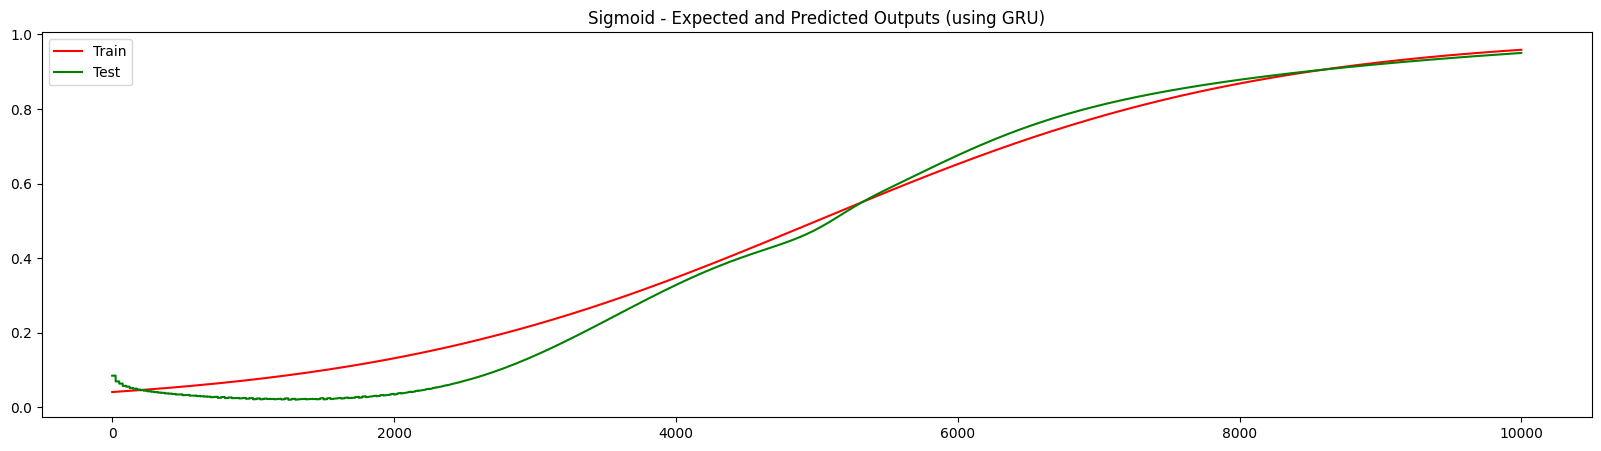

In [119]:
plt.figure(figsize=(20,5))
plt.plot(y, "red", label='Train')
plt.plot(predicted_output, "green", label='Test')
plt.title('Sigmoid - Expected and Predicted Outputs (using GRU)')
plt.legend()
plt.show()

# Question 3 - Summary

### Architecture Summaries

**LSTM Model:** This model consists of a single LSTM layer and a dense layer.

**GRU Model:** This model consists of a single GRU layer and a dense layer.

### Total Parameter Manual Calculations

LSTM Parameter Count Formula = 𝑚:𝑠𝑖𝑧𝑒𝑜𝑓𝑖𝑛𝑝𝑢𝑡, 𝑛:𝑠𝑖𝑧𝑒𝑜𝑓𝑜𝑢𝑡𝑝𝑢𝑡 • 𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠 = 4(𝑛𝑚 + 𝑛^2 + 𝑛)

**LSTM Model Paramaters: 10,451**

Layer 1 (LSTM) 
* m: (intput) = 1
* n: (output) = 50
* Formula: 4 * (1 * 50 + 50 * 50 + 50) = 10,400

Layer 2 (Dense)
* m: (input) = 50
* n: (output) = 1
* Formula: 4 * (50 * 1 + 1 * 1 + 1) = 10,400
* Layer 2 (Dense) = (25, 1, 1) = 50 (input size) * 1 (output size) + 1 (bias) * 1 (output size) = 50 + 1 = 51 
* Total = 10,400 + 51 = 10,451

Total number of parameters in the GRU RNN equals 3(𝑛^2+𝑛𝑚+2𝑛) where 𝑚 is the input dimension and 𝑛 is the output dimension.
GRU Parameter Count Formula = 3(𝑛^2+𝑛*𝑚+𝑛)
m: intput, n: output

**GRU Model Parameters: 8,001**

Layer 1 (GRU) = 3 * (50^2 + 50(1) + 2(50)) = 7,950

Layer 2 (Dense) = (25, 1, 1) = 50 (input size) * 1 (output size) + 1 (bias) * 1 (output size) = 50 + 1 = 51

Total parameters = 7,950 + 51 = 8,001

### Comparison with MLP from Assignment #2

Compared to my MLP model performance in assignment to, the LSTM and GRU models do not perform as well. This is evident in the MLP plots below compared to the LSTM/GRU plots above. The new models are not fitting the Sine nor the Sigmoid functions nearly as well. This may be solved be increasing the model complexities and epochs to learn more patterns, but overall the MLP has strong performance on these functions with minimal complexity. 

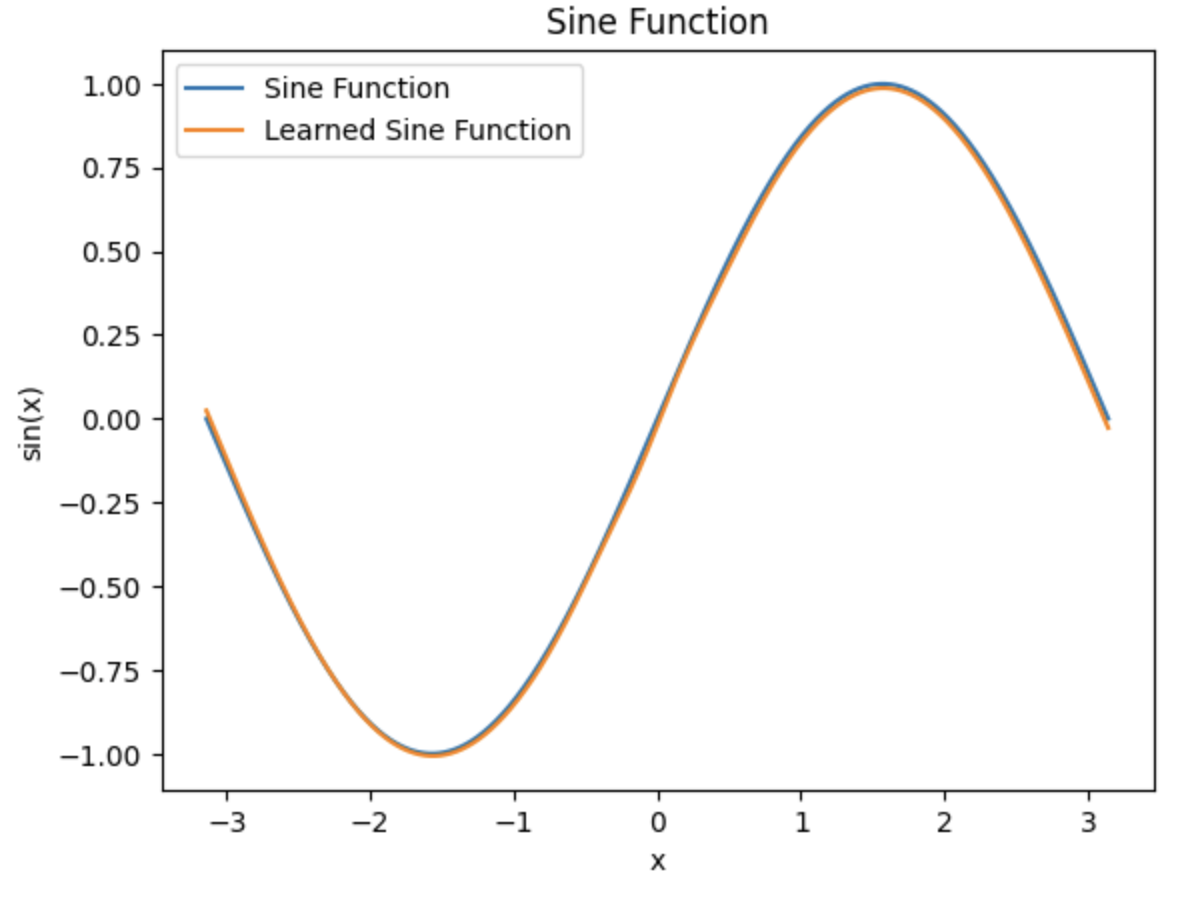

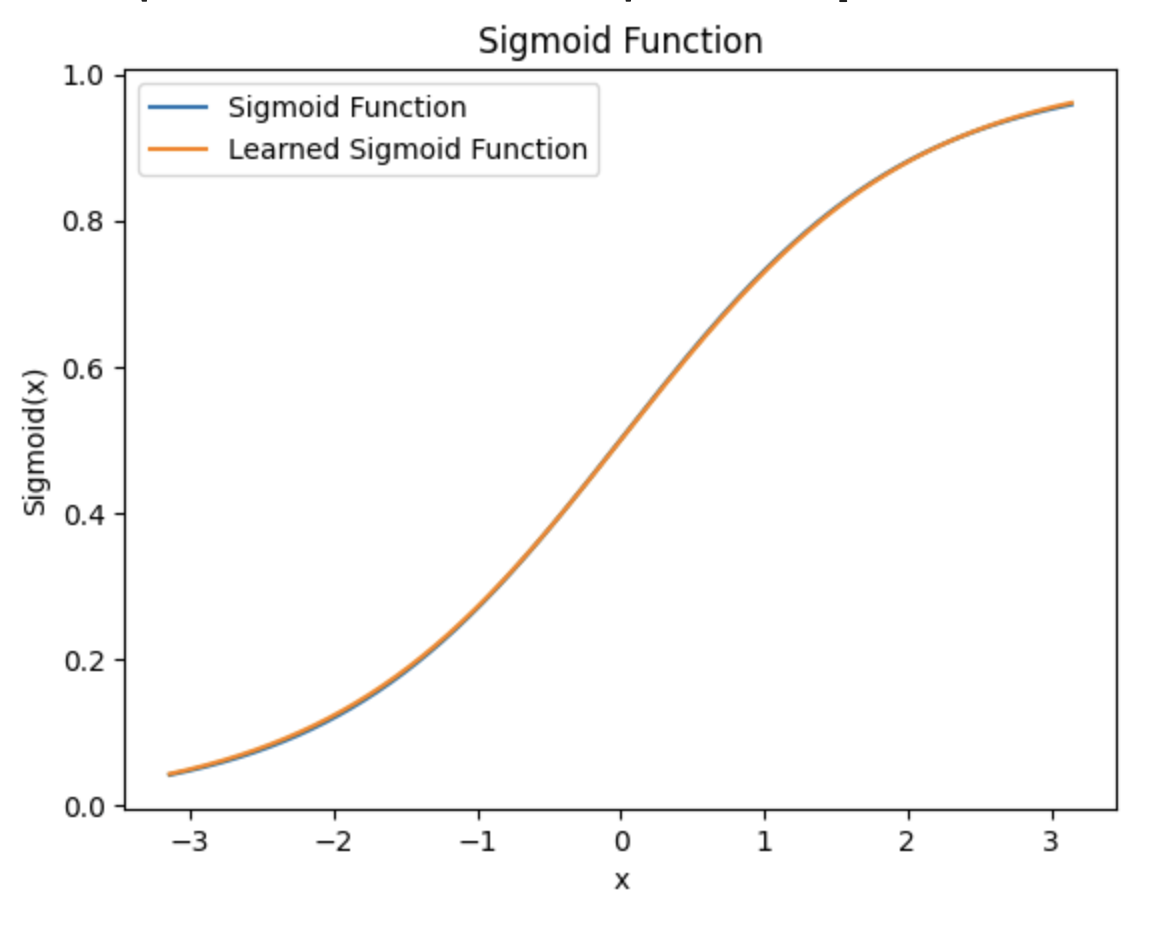